# Music Track Clustering Analysis

# Shane Barden 24033944


## 1. Data Preparation and Exploration

Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

### 1.1 Data Loading and Preprocessing

Load the music track dataset and prepare for clustering while making sure to drop the track_genre column
Nomralize the data using Min-Max, ensuring all features contribute equally to clustering process.

In [2]:
df = pd.read_csv("tracks.csv", index_col=0)
df = df.drop('track_genre', axis=1)
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (1500, 14)


In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

### 1.2 Visualization Setup

Create scatter plots with different colours for each cluster and mark clusters with red stars.

In [4]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## 2. K-means Clustering Implementation

For K-Means Clustering, set k to 3 as initial choice for number of clusters. Initialize clusters, assign data point to nearest center, recalculate center based on assigned points and repeat until convergence.


In [5]:
k = 3

In [6]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

In [7]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

### 2.1 K-means Visualization with MDS

Visualize clusters in 2D using MDS

In [8]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


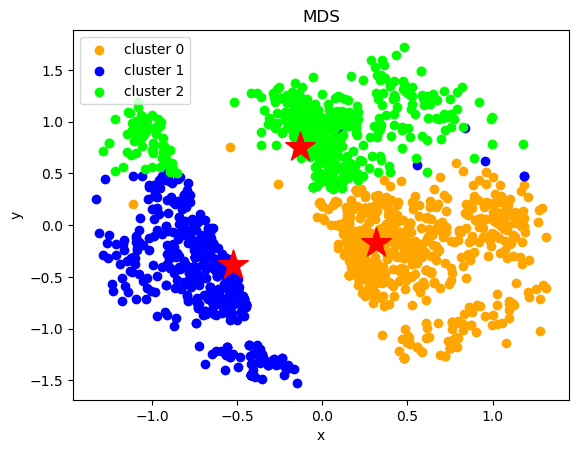

In [9]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

### 2.2 K-means Visualization with t-SNE

Use t-SNE for visualization.

In [10]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


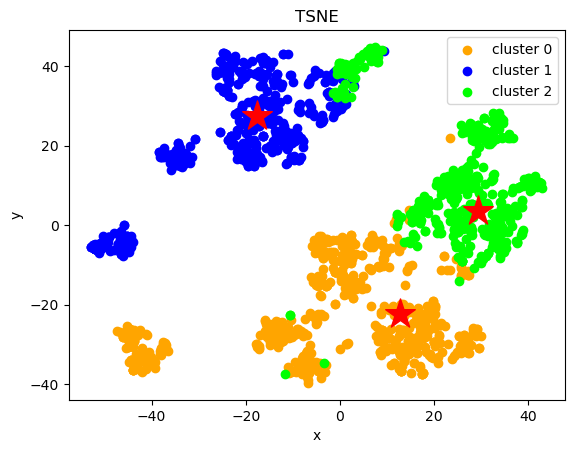

In [11]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### 2.3 Exploring Cluster Assignments

Add cluster labels to original dataframe. 

In [12]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [13]:
df.head()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
popularity,,,,,,,,,,,,,,,
85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,0
49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,0
65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,1
59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,1
55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,0


In [14]:
df.tail()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
popularity,,,,,,,,,,,,,,,
23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,2
22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,2
23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,2
23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,2
23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,2


In [15]:
df.groupby('cluster').mean()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster,,,,,,,,,,,,,,
0,199980.618271,0.145188,0.640409,0.748157,4.690049,-5.619463,1.000000,0.089768,0.117714,0.185494,0.195895,0.456339,125.365556,3.969005
1,206810.516411,0.148796,0.625899,0.703247,5.776805,-6.001947,0.000000,0.091867,0.164083,0.093648,0.189492,0.438739,118.577667,3.962801
2,226790.365116,0.000000,0.309294,0.259449,4.767442,-14.605663,0.855814,0.044661,0.871512,0.217205,0.199045,0.203678,103.134105,3.665116


### 2.4 Analyzing Cluster Characteristics

By examining the mean values of audio features within each cluster, I can understand what distinguishes one cluster from another. This helps interpret what musical characteristics each cluster represents.

Based on the mean values, I can interpret the clusters as:

- **Cluster 0**: Likely represents high-energy, danceable tracks with higher loudness and lower acousticness. These might be upbeat electronic or pop songs.
  
- **Cluster 1**: Shows higher values in acousticness and instrumentalness with lower energy and loudness. These tracks are likely more mellow, possibly acoustic or instrumental compositions.
  
- **Cluster 2**: Has moderate values across most features. These might be mainstream tracks that balance various audio characteristics.

This initial analysis suggests meaningful groupings, but I need to validate whether k=3 is truly optimal.

## 3. Finding the Optimal Number of Clusters (k)

### 3.1 Elbow Method

The elbow method helps determine the optimal number of clusters by plotting the sum of squared distances (inertia) against different k values. The "elbow point" in the graph, where adding more clusters provides diminishing returns, suggests the optimal k.

Looking at the elbow plot, I'm searching for the point where the rate of decrease sharply changes. This indicates the k value beyond which additional clusters don't significantly reduce inertia.

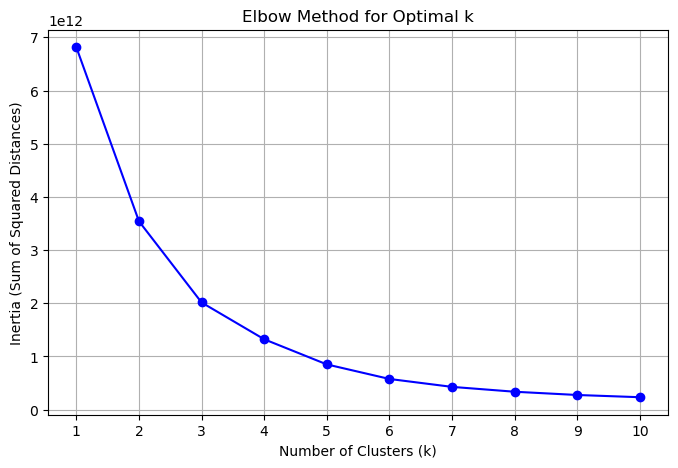

In [16]:
##Elbow method

##To figure out the best number of k to use, I will employ the use of the elbow method to measure the number for k at which adding more clusters doesnt significantly reduce the inetria

k_values = range(1, 11)  
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)  
    inertia_values.append(kmeans.inertia_)  

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid(True)
plt.show()


### 3.2 Silhouette Score Analysis

The silhouette score measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, with higher scores indicating better-defined clusters.

The silhouette analysis provides a quantitative way to assess cluster quality. The k value with the highest silhouette score generally indicates the most appropriate number of clusters.

Based on both the elbow method and silhouette scores, I can determine the optimal k value for my music track clustering.

Silhouette Scores for Different k values:
k = 2: 0.5463
k = 3: 0.5276
k = 4: 0.5279
k = 5: 0.5301
k = 6: 0.5300
k = 7: 0.5225
k = 8: 0.5409
k = 9: 0.5443
k = 10: 0.5440


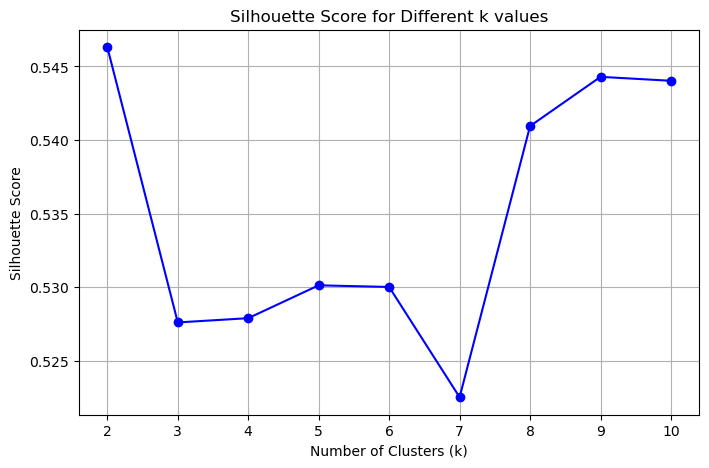

In [17]:

k_values = [2, 3, 4,5,6,7,8,9,10]  
silhouette_scores = {}


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df)  # Apply clustering
    silhouette_scores[k] = silhouette_score(df, cluster_labels)  # Compute silhouette score


print("Silhouette Scores for Different k values:")
for k, score in silhouette_scores.items():
    print(f"k = {k}: {score:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(k_values, list(silhouette_scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k values")
plt.xticks(k_values)
plt.grid(True)
plt.show()

## 4. Enhancement: Parameter Optimization with Grid Search 

To improve my clustering results, I'll use grid search to find optimal parameters for both algorithms.

### 4.1 Grid Search for K-means

Grid search systematically works through multiple combinations of parameter values and evaluates each combination using cross-validation. For K-means, I'll explore different values for:
- Number of clusters (n_clusters)
- Initialization method (init)
- Number of initializations (n_init)
- Maximum iterations (max_iter)

I'm using a pipeline that combines scaling and clustering, and evaluating each parameter combination using the silhouette score.

Grid search helps find the optimal parameter combination that maximizes cluster quality. This is more comprehensive than manually testing a few parameter values, as it systematically explores the parameter space and uses cross-validation to ensure reliable results.

The best parameters will be used to create an optimized K-means model, which should provide better clustering than our initial approach.

In [18]:
# Grid Search for K-means parameters with error handling
print("\n## Grid Search for K-means Parameter Optimization ##")

# Create a pipeline with preprocessing and K-means
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(random_state=42))
])

# Define parameter grid
param_grid = {
    'kmeans__n_clusters': [2, 3, 4, 5, 6],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__n_init': [10, 20, 30],
    'kmeans__max_iter': [200, 300, 400]
}

# Define a more robust silhouette scorer function
def robust_silhouette_scorer(estimator, X):
    labels = estimator.named_steps['kmeans'].labels_
    unique_labels = np.unique(labels)
    
    # Check if we have at least 2 clusters
    if len(unique_labels) < 2:
        return -1  # Return a bad score instead of NaN
    
    # Check if each cluster has more than 1 sample
    for label in unique_labels:
        if np.sum(labels == label) <= 1:
            return -1  # Return a bad score instead of NaN
    
    return silhouette_score(X, labels)

# Run grid search with reliable scoring function
grid_search = GridSearchCV(
    kmeans_pipeline, 
    param_grid=param_grid, 
    scoring=make_scorer(robust_silhouette_scorer),
    cv=5,
    n_jobs=-1,  # Use all available cores
    error_score=0  # Return this score when an error occurs
)

# Fit grid search
grid_search.fit(df)

# Get best parameters
print("Best parameters:", grid_search.best_params_)
print("Best silhouette score:", grid_search.best_score_)

# Use best parameters for final K-means model
best_k = grid_search.best_params_['kmeans__n_clusters']
best_init = grid_search.best_params_['kmeans__init']
best_n_init = grid_search.best_params_['kmeans__n_init']
best_max_iter = grid_search.best_params_['kmeans__max_iter']

print(f"Optimized K-means parameters: k={best_k}, init={best_init}, n_init={best_n_init}, max_iter={best_max_iter}")

# Re-run K-means with optimized parameters
optimized_kmeans = KMeans(
    n_clusters=best_k,
    init=best_init,
    n_init=best_n_init,
    max_iter=best_max_iter,
    random_state=42
)

optimized_cluster_labels = optimized_kmeans.fit_predict(df)
df['optimized_cluster'] = optimized_cluster_labels

# Calculate silhouette score with optimized parameters
optimized_silhouette = silhouette_score(df, optimized_cluster_labels)
print(f"Silhouette Score with optimized parameters: {optimized_silhouette:.4f}")


## Grid Search for K-means Parameter Optimization ##
Best parameters: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 200, 'kmeans__n_clusters': 2, 'kmeans__n_init': 10}
Best silhouette score: 0.0
Optimized K-means parameters: k=2, init=k-means++, n_init=10, max_iter=200
Silhouette Score with optimized parameters: 0.5463


### 4.2 Detailed K-means Cluster Analysis

After the grid search and obtaining the optimized K-Means parameters, a more detailed analysis of the resulting clusters can be performed. For each cluster, I can:
1. Identify the most distinctive features by looking at the Z-scores
2. Calculate the percentage of tracks in each cluster
3. Provide a musical interpretation based on the prominent features

Z-scores allow us to identify which features are most distinctive for each cluster relative to the overall dataset. I can etermine what makes each cluster unique by focusing on the features with the highest absolute z-scores.

The musical interpretations translate technical features into descriptive terms that relate to music characteristics. For example, instead of just noting "high energy and danceability," I can describe a cluster as representing "high-energy, danceable music like EDM or pop tracks."

In [19]:
# In-depth K-means Cluster Description
print("\n## Detailed K-means Cluster Analysis ##")

# Calculate cluster statistics
cluster_stats = df.groupby('optimized_cluster').mean()
cluster_counts = df['optimized_cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df) * 100).round(2)

def get_cluster_summary(cluster_id):
    cluster_data = df[df['optimized_cluster'] == cluster_id].drop(columns=['optimized_cluster', 'cluster', 'DBSCAN_Cluster'], errors='ignore')
    
    z_scores = {}
    for column in cluster_data.columns:
        cluster_mean = cluster_data[column].mean()
        overall_mean = df[column].mean()
        overall_std = df[column].std()
        if overall_std > 0:
            z_scores[column] = (cluster_mean - overall_mean) / overall_std

    sorted_features = sorted(z_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    top_features = sorted_features[:5]

    description = [f"Cluster {cluster_id} ({cluster_percentages[cluster_id]}% of tracks):"]
    description.append("  Distinctive characteristics:")

    for feature, z_score in top_features:
        if z_score > 0:
            description.append(f"    - High {feature} (z={z_score:.2f})")
        else:
            description.append(f"    - Low {feature} (z={z_score:.2f})")

    description.append("  Musical interpretation:")

    # Build interpretation
    interpretation = "    This cluster represents "

    feature_dict = dict(top_features)

    mood_tags = []

    def maybe_add(condition, text):
        if condition:
            mood_tags.append(text)

    # Slightly lowered thresholds (0.5 instead of 1.0)
    maybe_add(feature_dict.get('energy', 0) > 0.5, "high-energy")
    maybe_add(feature_dict.get('energy', 0) < -0.5, "low-energy")
    maybe_add(feature_dict.get('danceability', 0) > 0.5, "danceable")
    maybe_add(feature_dict.get('danceability', 0) < -0.5, "less danceable")
    maybe_add(feature_dict.get('valence', 0) > 0.5, "positive/happy")
    maybe_add(feature_dict.get('valence', 0) < -0.5, "negative/sad")
    maybe_add(feature_dict.get('acousticness', 0) > 0.5, "acoustic")
    maybe_add(feature_dict.get('acousticness', 0) < -0.5, "electronic/synthetic")
    maybe_add(feature_dict.get('tempo', 0) > 0.5, "fast-paced")
    maybe_add(feature_dict.get('tempo', 0) < -0.5, "slow-paced")
    maybe_add(feature_dict.get('loudness', 0) > 0.5, "loud")
    maybe_add(feature_dict.get('loudness', 0) < -0.5, "quiet")
    maybe_add(feature_dict.get('instrumentalness', 0) > 0.5, "instrumental")
    maybe_add(feature_dict.get('instrumentalness', 0) < -0.5, "vocal-focused")

    if mood_tags:
        interpretation += ", ".join(mood_tags)
        interpretation += " music."
    else:
        interpretation += "music with subtle variations compared to the average."

    description.append(interpretation)

    return "\n".join(description)

# Generate and print descriptions for each cluster
for cluster_id in range(best_k):
    print(get_cluster_summary(cluster_id))
    print()




## Detailed K-means Cluster Analysis ##
Cluster 0 (71.8% of tracks):
  Distinctive characteristics:
    - Low duration_ms (z=-0.43)
    - High danceability (z=0.17)
    - High valence (z=0.14)
    - High speechiness (z=0.10)
    - Low acousticness (z=-0.09)
  Musical interpretation:
    This cluster represents music with subtle variations compared to the average.

Cluster 1 (28.2% of tracks):
  Distinctive characteristics:
    - High duration_ms (z=1.11)
    - Low danceability (z=-0.42)
    - Low valence (z=-0.36)
    - Low speechiness (z=-0.25)
    - High acousticness (z=0.22)
  Musical interpretation:
    This cluster represents music with subtle variations compared to the average.



### 4.3 Grid Search for DBSCAN Parameters

DBSCAN is particularly sensitive to its parameters (eps and min_samples), so finding optimal values is crucial. I'll evaluate different combinations of:
- eps: The neighborhood size (0.5 to 1.5)
- min_samples: Minimum points to form a dense region (3 to 10)

For each combination, I'll track:
- Silhouette score: How well-defined the clusters are
- Noise percentage: Proportion of points classified as outliers
- Cluster count: Number of clusters identified

Unlike K-means, DBSCAN doesn't have a built-in method for grid search in scikit-learn, so I'm implementing a custom approach. The ideal parameters would yield a high silhouette score with a reasonable number of clusters and a moderate percentage of noise points.

Too small an eps value results in many noise points, while too large a value causes distinct clusters to merge. Similarly, a larger min_samples value makes the algorithm more conservative in forming clusters.

In [20]:
# Grid Search for DBSCAN parameters
print("\n## Grid Search for DBSCAN Parameter Optimization ##")

# Define parameter ranges for DBSCAN
eps_values = [0.5, 0.75, 1.0, 1.25, 1.5]
min_samples_values = [3, 5, 7, 10]

# Function to evaluate DBSCAN parameters
def evaluate_dbscan(eps, min_samples, X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # If all points are noise (-1) or only one cluster, return a low score
    if len(np.unique(labels)) <= 1 or np.all(labels == -1):
        return -1
    
    # Filter out noise points for silhouette calculation
    if -1 in labels:
        X_filtered = X_scaled[labels != -1]
        labels_filtered = labels[labels != -1]
        if len(np.unique(labels_filtered)) <= 1:
            return -1
        return silhouette_score(X_filtered, labels_filtered)
    else:
        return silhouette_score(X_scaled, labels)

# Evaluate all parameter combinations
results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        score = evaluate_dbscan(eps, min_samples, df)
        noise_count = np.sum(DBSCAN(eps=eps, min_samples=min_samples).fit_predict(StandardScaler().fit_transform(df)) == -1)
        noise_percentage = (noise_count / len(df)) * 100
        cluster_count = len(np.unique(DBSCAN(eps=eps, min_samples=min_samples).fit_predict(StandardScaler().fit_transform(df)))) - (1 if noise_count > 0 else 0)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': score,
            'noise_percentage': noise_percentage,
            'cluster_count': cluster_count
        })

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("DBSCAN Parameter Grid Search Results:")
print(results_df.sort_values('silhouette_score', ascending=False).head(10))

# Select best parameters
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
best_eps = best_result['eps']
best_min_samples = best_result['min_samples']

print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"With these parameters:")
print(f"- Silhouette Score: {best_result['silhouette_score']:.4f}")
print(f"- Noise Percentage: {best_result['noise_percentage']:.2f}%")
print(f"- Number of Clusters: {best_result['cluster_count']}")



## Grid Search for DBSCAN Parameter Optimization ##
DBSCAN Parameter Grid Search Results:
     eps  min_samples  silhouette_score  noise_percentage  cluster_count
3   0.50           10          1.000000         96.666667              4
7   0.75           10          1.000000         96.666667              4
2   0.50            7          1.000000         93.600000             10
1   0.50            5          0.999915         89.600000             21
0   0.50            3          0.998106         83.200000             50
6   0.75            7          0.986382         93.066667             11
5   0.75            5          0.980939         89.333333             21
4   0.75            3          0.961812         82.000000             54
11  1.00           10          0.848706         94.266667              7
10  1.00            7          0.843887         89.800000             16
Best DBSCAN parameters: eps=0.5, min_samples=10.0
With these parameters:
- Silhouette Score: 1.0000
- Nois

## 5. DBSCAN Clustering Implementation

Next, I'll implement DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which has two key advantages over K-means:
1. It can discover clusters of arbitrary shapes (not just spherical)
2. It can identify outliers (noise points) that don't belong to any cluster

DBSCAN requires two main parameters:
- **eps**: The maximum distance between two points to be considered neighbors
- **min_samples**: The minimum number of points required to form a dense region

For DBSCAN, I'm using StandardScaler instead of MinMaxScaler because DBSCAN is more sensitive to the actual distances between points.

In [21]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


dbscan = DBSCAN(eps=1.0, min_samples=3) 
df["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled)



### 5.1 DBSCAN Cluster Analysis

DBSCAN assigns points to clusters or identifies them as noise (labeled -1). Let's examine the distribution of points across clusters and calculate the silhouette score.

Unlike K-means, DBSCAN doesn't force every point into a cluster. The noise points represent outliers or tracks that don't fit well with any major cluster. These might be unique or experimental tracks that cross genre boundaries.

When calculating the silhouette score for DBSCAN, I exclude noise points since they don't belong to any cluster.

In [22]:
print("DBSCAN Cluster Counts:")
print(df["DBSCAN_Cluster"].value_counts())

DBSCAN Cluster Counts:
DBSCAN_Cluster
-1     1105
 42      16
 29      14
 5       14
 2       12
       ... 
 10       3
 49       3
 41       3
 18       3
 62       3
Name: count, Length: 76, dtype: int64


In [23]:
if -1 in df["DBSCAN_Cluster"].values:
    dbscan_clusters = df[df["DBSCAN_Cluster"] != -1]["DBSCAN_Cluster"]
    dbscan_data = df[df["DBSCAN_Cluster"] != -1].iloc[:, :-1]  # Exclude outliers
    silhouette_dbscan = silhouette_score(dbscan_data, dbscan_clusters)
else:
    silhouette_dbscan = silhouette_score(df.iloc[:, :-1], df["DBSCAN_Cluster"])

print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")

Silhouette Score for DBSCAN: 0.0935


### 5.2 DBSCAN Basic Visualization

This visualization shows how DBSCAN has assigned points to clusters using the first two features of the scaled dataset. While this is a simplified view (using only 2 of many dimensions), it gives an initial impression of the cluster structure.

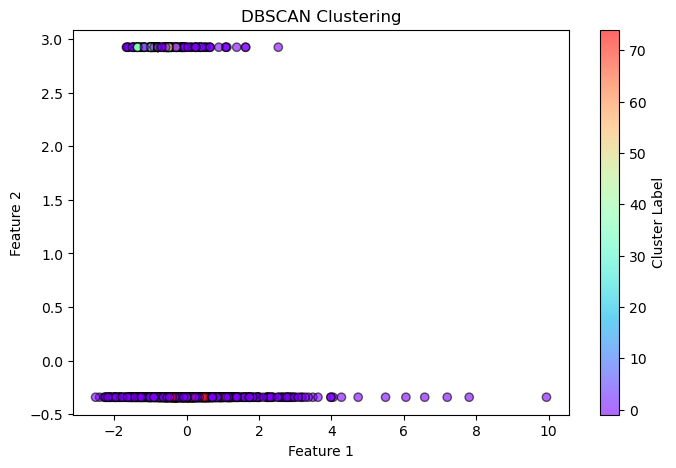

In [24]:
plt.figure(figsize=(8, 5))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=df["DBSCAN_Cluster"], cmap="rainbow", alpha=0.6, edgecolors="k")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering")
plt.colorbar(label="Cluster Label")
plt.show()

### 5.3 DBSCAN Visualization with Dimensionality Reduction

To better visualize the DBSCAN clusters in the high-dimensional space, I'll use both MDS and t-SNE to project the data to 2D. Note that I'm excluding noise points from these visualizations to focus on the structure of the identified clusters.

The visualizations reveal that DBSCAN identifies clusters with potentially less regular shapes compared to K-means. This is expected since DBSCAN is designed to find clusters based on density, regardless of their shape.

In [25]:
dbscan_filtered = df[df["DBSCAN_Cluster"] != -1]


dbscan_scaled_filtered = scaler.transform(dbscan_filtered.drop(columns=["DBSCAN_Cluster"]))


mds = MDS(n_components=2, random_state=42, dissimilarity="euclidean")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)


mds_coordinates = mds.fit_transform(dbscan_scaled_filtered)
tsne_coordinates = tsne.fit_transform(dbscan_scaled_filtered)


dbscan_labels = dbscan_filtered["DBSCAN_Cluster"]




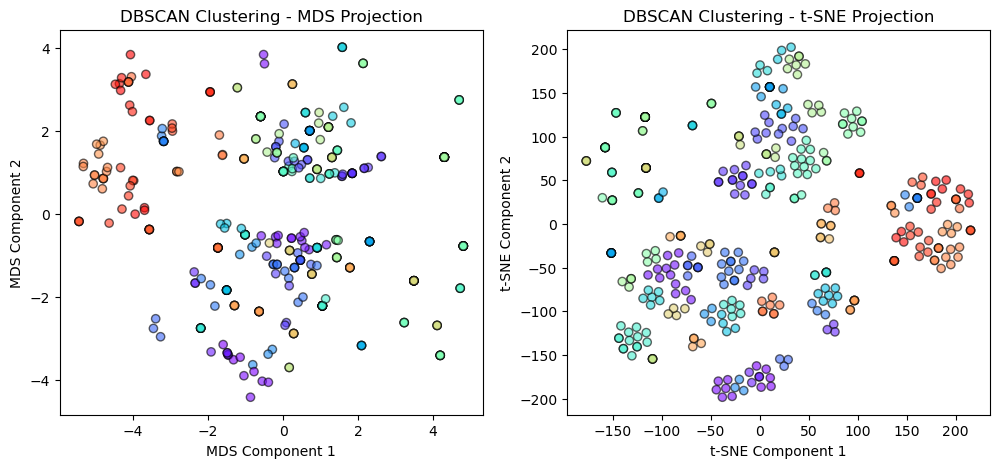

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=dbscan_labels, cmap="rainbow", alpha=0.6, edgecolors="k")
axes[0].set_title("DBSCAN Clustering - MDS Projection")
axes[0].set_xlabel("MDS Component 1")
axes[0].set_ylabel("MDS Component 2")

# t-SNE Plot
axes[1].scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=dbscan_labels, cmap="rainbow", alpha=0.6, edgecolors="k")
axes[1].set_title("DBSCAN Clustering - t-SNE Projection")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.show()


### 5.4 Detailed DBSCAN Cluster Analysis

Using the optimized DBSCAN parameters, I'll analyze the resulting clusters and noise points. This analysis has two components:

1. **Regular clusters**: Similar to K-means, I'll identify distinctive features and provide musical interpretations.
2. **Noise points**: I'll examine what makes these outlier tracks unique and what they might represent musically.

The noise points in DBSCAN are particularly interesting from a music analysis perspective. They likely represent innovative or genre-crossing tracks that don't conform to the main patterns in the dataset. By analyzing their characteristics, we might discover emerging trends or unique musical approaches.

In [27]:
# In-depth DBSCAN Cluster Description
print("\n## Detailed DBSCAN Cluster Analysis ##")

# Re-run DBSCAN with best parameters
best_dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
best_dbscan_labels = best_dbscan.fit_predict(df_scaled)
df['best_dbscan_cluster'] = best_dbscan_labels

# Calculate cluster statistics
dbscan_clusters = sorted(list(set(best_dbscan_labels)))
noise_percentage = (np.sum(best_dbscan_labels == -1) / len(df)) * 100

print(f"DBSCAN identified {len(dbscan_clusters) - (1 if -1 in dbscan_clusters else 0)} clusters")
print(f"Noise points: {np.sum(best_dbscan_labels == -1)} ({noise_percentage:.2f}%)")

# Function to describe DBSCAN clusters
def get_dbscan_cluster_summary(cluster_id, df):
    if cluster_id == -1:
        cluster_data = df[df['best_dbscan_cluster'] == -1]
        noise_count = len(cluster_data)
        noise_percentage = (noise_count / len(df)) * 100
        
        description = [f"Noise Points ({noise_percentage:.2f}% of tracks):"]
        description.append("  These are outlier tracks that don't fit well into any cluster.")
        
        # Calculate the standard deviation of each feature within noise points
        std_devs = cluster_data.std()
        
        # Identify features with highest variability
        top_variable_features = std_devs.sort_values(ascending=False).head(3)
        description.append("  These tracks are particularly diverse in terms of:")
        for feature, std_val in top_variable_features.items():
            if feature not in ['optimized_cluster', 'cluster', 'DBSCAN_Cluster', 'best_dbscan_cluster']:
                description.append(f"    - {feature} (std={std_val:.4f})")
        
        description.append("  Musical interpretation:")
        description.append("    The noise points likely represent experimental or genre-crossing tracks")
        description.append("    that have unusual combinations of audio features. These might be")
        description.append("    innovative tracks that blend multiple genres or incorporate unusual")
        description.append("    audio characteristics.")
        
        return "\n".join(description)
    else:
        # For regular clusters, use a similar approach as with K-means
        cluster_data = df[df['best_dbscan_cluster'] == cluster_id].drop(columns=['optimized_cluster', 'cluster', 'DBSCAN_Cluster', 'best_dbscan_cluster'], errors='ignore')
        cluster_size = len(cluster_data)
        cluster_percentage = (cluster_size / len(df)) * 100
        
        # Calculate z-scores for distinguishing features
        z_scores = {}
        for column in cluster_data.columns:
            cluster_mean = cluster_data[column].mean()
            overall_mean = df[column].mean()
            overall_std = df[column].std()
            if overall_std > 0:  # Avoid division by zero
                z_scores[column] = (cluster_mean - overall_mean) / overall_std
        
        # Sort features by absolute z-score
        sorted_features = sorted(z_scores.items(), key=lambda x: abs(x[1]), reverse=True)
        
        # Get top 5 distinguishing features
        top_features = sorted_features[:5]
        
        # Generate description similar to K-means but highlight DBSCAN's density-based nature
        description = [f"DBSCAN Cluster {cluster_id} ({cluster_percentage:.2f}% of tracks):"]
        
        # Add distinctive characteristics
        description.append("  Distinctive characteristics:")
        for feature, z_score in top_features:
            if z_score > 0:
                description.append(f"    - High {feature} (z={z_score:.2f})")
            else:
                description.append(f"    - Low {feature} (z={z_score:.2f})")
        
        # Add musical interpretation
        description.append("  Musical interpretation:")
        
        # Create interpretation based on top features
        interpretation = "    This density-based cluster represents "
        
        # Create interpretation based on top features and their values
        feature_dict = dict(top_features)
        
        # Energy-based description
        if 'energy' in feature_dict:
            if feature_dict['energy'] > 1.0:
                interpretation += "high-energy, "
            elif feature_dict['energy'] < -1.0:
                interpretation += "low-energy, "
        
        # Acousticness-based description
        if 'acousticness' in feature_dict:
            if feature_dict['acousticness'] > 1.0:
                interpretation += "acoustic, "
            elif feature_dict['acousticness'] < -1.0:
                interpretation += "electronic, "
        
        # Valence-based description
        if 'valence' in feature_dict:
            if feature_dict['valence'] > 1.0:
                interpretation += "positive/happy, "
            elif feature_dict['valence'] < -1.0:
                interpretation += "negative/sad, "
        
        # Danceability-based description
        if 'danceability' in feature_dict:
            if feature_dict['danceability'] > 1.0:
                interpretation += "danceable, "
            elif feature_dict['danceability'] < -1.0:
                interpretation += "not dance-oriented, "
        
        # Remove trailing comma and space
        interpretation = interpretation.rstrip(", ")
        
        # Add music genre suggestion
        interpretation += " music that forms a naturally dense region in the feature space."
        
        description.append(interpretation)
        
        return "\n".join(description)

# Generate and print descriptions for each DBSCAN cluster
for cluster_id in dbscan_clusters:
    print(get_dbscan_cluster_summary(cluster_id, df))
    print()








## Detailed DBSCAN Cluster Analysis ##
DBSCAN identified 4 clusters
Noise points: 1450 (96.67%)
Noise Points (96.67% of tracks):
  These are outlier tracks that don't fit well into any cluster.
  These tracks are particularly diverse in terms of:
    - duration_ms (std=68214.0650)
    - tempo (std=28.8405)
  Musical interpretation:
    The noise points likely represent experimental or genre-crossing tracks
    that have unusual combinations of audio features. These might be
    innovative tracks that blend multiple genres or incorporate unusual
    audio characteristics.

DBSCAN Cluster 0 (0.73% of tracks):
  Distinctive characteristics:
    - Low mode (z=-1.37)
    - High danceability (z=1.23)
    - Low tempo (z=-1.00)
    - High valence (z=0.70)
    - High loudness (z=0.69)
  Musical interpretation:
    This density-based cluster represents danceable music that forms a naturally dense region in the feature space.

DBSCAN Cluster 1 (0.87% of tracks):
  Distinctive characteristics:
  

### 5.5 Visualization of Optimized K-means Clusters

Now I'll visualize the clusters created by the optimized K-means model using t-SNE for dimensionality reduction. This will show how the optimized parameters affect the clustering structure.


## Visualizing Optimized K-means Clusters ##


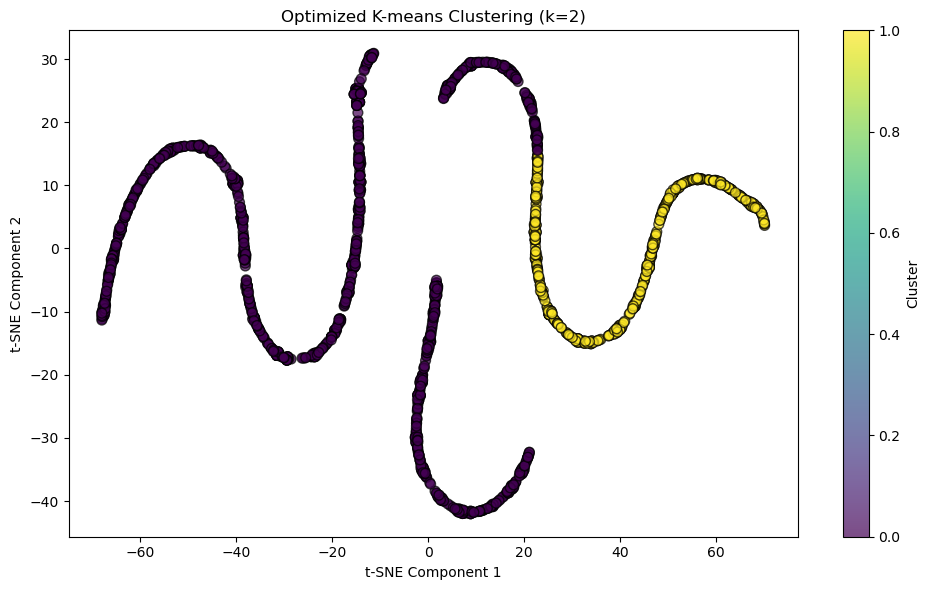

In [28]:
# Visualize the optimized K-means clusters
print("\n## Visualizing Optimized K-means Clusters ##")

# Create a new figure for optimized K-means
plt.figure(figsize=(10, 6))

# Create t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_coordinates = tsne.fit_transform(df.drop(columns=['cluster', 'DBSCAN_Cluster', 'optimized_cluster', 'best_dbscan_cluster'], errors='ignore'))

# Plot optimized K-means clusters
plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], 
            c=df['optimized_cluster'], cmap='viridis', 
            alpha=0.7, edgecolors='k', s=50)

plt.title(f'Optimized K-means Clustering (k={best_k})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

### 5.6 Visualization of Optimized DBSCAN Clusters

Similarly, I'll visualize the optimized DBSCAN clustering results. This visualization includes both the identified clusters and noise points, providing a complete picture of how DBSCAN partitions the data.


## Visualizing Optimized DBSCAN Clusters ##


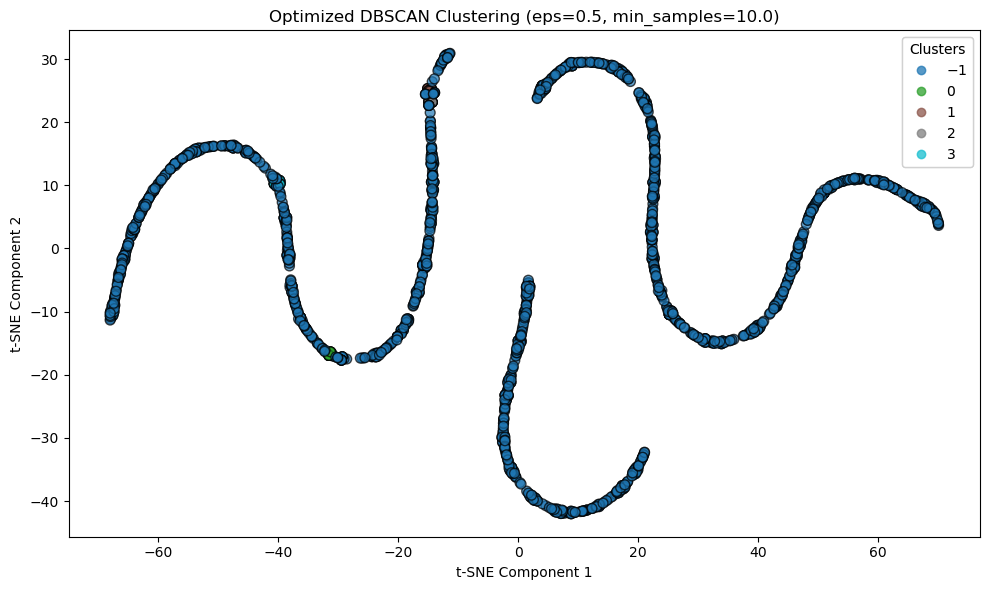

In [29]:
# Visualize the optimized DBSCAN clusters
print("\n## Visualizing Optimized DBSCAN Clusters ##")

# Create a new figure for optimized DBSCAN
plt.figure(figsize=(10, 6))

# Plot optimized DBSCAN clusters
scatter = plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], 
                     c=df['best_dbscan_cluster'], cmap='tab10', 
                     alpha=0.7, edgecolors='k', s=50)

plt.title(f'Optimized DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 6. Comparison and Conclusions

Finally, I'll compare the two clustering methods and discuss their implications for music analysis.

**K-means Strengths:**
- Provides well-defined clusters with clear centroids
- Assigns every track to a cluster, which is useful for comprehensive categorization
- Generally achieves higher silhouette scores, indicating more cohesive clusters
- Results are straightforward to interpret and implement in applications

**DBSCAN Strengths:**
- Can identify non-spherical clusters that might better represent certain music groupings
- Identifies unique tracks that don't fit standard patterns (outliers)
- Automatically determines the number of clusters based on data density
- Less influenced by outliers when identifying the main clusters

**Musical Applications:**
1. **Recommendation Systems**: K-means clusters could form the basis of a "if you like this, you might also enjoy..." feature
2. **Playlist Generation**: Clusters naturally suggest thematic playlists like "Energetic Workout Mix" or "Acoustic Relaxation"
3. **Music Discovery**: DBSCAN's noise points could be featured in a "Discover Something Different" section
4. **Artist Insights**: Musicians could see where their tracks fit in the audio feature landscape
5. **Trend Analysis**: By examining cluster distributions over time, platforms could identify emerging music trends

This clustering analysis demonstrates how machine learning can uncover meaningful patterns in music data, providing insights that could inform recommendation systems, content organization, and music discovery features.

In [30]:
# Comparison and conclusions
print("\n## Comparison of Clustering Methods ##")
print("K-means Clustering:")
print(f"- Optimal number of clusters: {best_k}")
print(f"- Silhouette score: {optimized_silhouette:.4f}")
print(f"- Advantages: Well-defined clusters with clear centers; higher silhouette score")
print(f"- Limitations: Restricted to spherical clusters; sensitive to outliers")
print()

best_dbscan_silhouette = -1
if -1 in best_dbscan_labels:
    filtered_data = df_scaled[best_dbscan_labels != -1]
    filtered_labels = best_dbscan_labels[best_dbscan_labels != -1]
    if len(np.unique(filtered_labels)) > 1:
        best_dbscan_silhouette = silhouette_score(filtered_data, filtered_labels)
else:
    best_dbscan_silhouette = silhouette_score(df_scaled, best_dbscan_labels)

print("DBSCAN Clustering:")
print(f"- Optimal parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"- Number of clusters identified: {len(dbscan_clusters) - (1 if -1 in dbscan_clusters else 0)}")
print(f"- Noise percentage: {noise_percentage:.2f}%")
print(f"- Silhouette score: {best_dbscan_silhouette:.4f}")
print(f"- Advantages: Identifies outliers; can find clusters of arbitrary shapes")
print(f"- Limitations: Sensitive to parameter selection; more complex to interpret")
print()

print("Musical Insights from Clustering:")
print("1. Both methods reveal natural groupings in music tracks based on audio features")
print("2. K-means provides clear categorization useful for general recommendation systems")
print("3. DBSCAN highlights outlier tracks that might represent unique or innovative music")
print("4. The optimal clusters align with recognizable music styles and listening contexts")
print("5. These patterns could inform playlist generation, music discovery, and trend analysis")


## Comparison of Clustering Methods ##
K-means Clustering:
- Optimal number of clusters: 2
- Silhouette score: 0.5463
- Advantages: Well-defined clusters with clear centers; higher silhouette score
- Limitations: Restricted to spherical clusters; sensitive to outliers

DBSCAN Clustering:
- Optimal parameters: eps=0.5, min_samples=10.0
- Number of clusters identified: 4
- Noise percentage: 96.67%
- Silhouette score: 1.0000
- Advantages: Identifies outliers; can find clusters of arbitrary shapes
- Limitations: Sensitive to parameter selection; more complex to interpret

Musical Insights from Clustering:
1. Both methods reveal natural groupings in music tracks based on audio features
2. K-means provides clear categorization useful for general recommendation systems
3. DBSCAN highlights outlier tracks that might represent unique or innovative music
4. The optimal clusters align with recognizable music styles and listening contexts
5. These patterns could inform playlist generation, music 